In [29]:
import os
import pickle
import re

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("ticks")

with open("01a_preprocessing_s1.pkl", "rb") as infile:
    pg_s1 = pickle.load(infile)

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import matplotlib.pyplot as plt
from autoprot import analysis as ana
from autoprot import preprocessing as pp
from autoprot import visualization as vis

## Statistical analysis

In [30]:
# two sample ranksum analysis
pg_s1 = ana.rank_prod(
    pg_s1,
    reps=[
        pg_s1.filter(regex="TPA.*S\d+_R\d+.*_imputed").columns.tolist(),
        pg_s1.filter(regex="WT.*_imputed").columns.tolist(),
    ],
    cond="_S1_interactome_ranksum",
    print_r=True,
)

rankProd: Assuming a two sample test with:
Sample 1: 
	sum_iBAQ.TPA_S1_R1_median_corrected_normalized_imputed, 
	sum_iBAQ.TPA_S1_R2_median_corrected_normalized_imputed, 
	sum_iBAQ.TPA_S1_R3_median_corrected_normalized_imputed
Sample 2: 
	sum_iBAQ.WT_S1_R1_median_corrected_normalized_imputed, 
	sum_iBAQ.WT_S1_R2_median_corrected_normalized_imputed, 
	sum_iBAQ.WT_S1_R3_median_corrected_normalized_imputed
Class labels: 0, 0, 0, 1, 1, 1
 The data is from  1 different origins 
 
Rank Sum analysis for two-class case 
 
Rank Sum analysis for unpaired case 
 

 done  
Loading required package: pak
Warning message:
package 'pak' was built under R version 4.2.3 
â„¹ Loading metadata database
âœ” Loading metadata database ... done

 
â„¹ No downloads are needed
âœ” 1 pkg + 183 deps: kept 61 [11.4s]
Loading required package: github::kreutz-lab/DIMAR
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown 

In [31]:
pg_s1["POI"] = False

pg_s1["POI"] = pg_s1["Gene names"].astype(str).str.lower().str.capitalize()
# Pex39 has no gene name
pg_s1.loc[pg_s1["Protein names"].str.contains("YJR012C", na=False), "POI"] = "Pex39"

## Plotting Volcano Plots

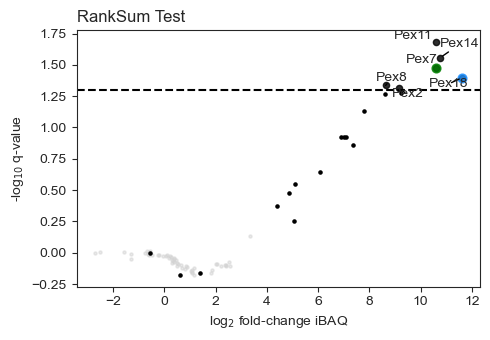

In [32]:
from plotly.subplots import make_subplots

fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey="all")

inter_fig = make_subplots(1, 1, shared_yaxes=True, subplot_titles=["RankSum"])

highlight = pg_s1[
    (
        (pg_s1["Gene names"].str.contains("PEX*", na=False))
        & (pg_s1["adj.P.Val_class1>class2_S1_interactome_ranksum"] < 0.05)
        | (pg_s1["Gene names"] == "PNC1")
    )
].index

highlight_cargo = pg_s1[(pg_s1["Gene names"].isin(["POT1", "GPD1"]) != False)].index

highlight_pex39 = pg_s1[pg_s1["Protein names"].str.contains("YJR012C", na=False)].index
highlight_pex18 = pg_s1[pg_s1["Gene names"].isin(["PEX21", "PEX18"])].index
highlight_pex7 = pg_s1[pg_s1["Gene names"] == "PEX7"].index

highlight_nonsig = pg_s1[
    (pg_s1["Gene names"].str.contains("PEX*", na=False))
    & (pg_s1["adj.P.Val_class1>class2_S1_interactome_ranksum"] >= 0.05)
].index

vis.volcano(
    pg_s1,
    title="RankSum Test",
    log_fc_colname=f"logFC_S1_interactome_ranksum",
    log_fc_thresh=None,
    p_colname="adj.P.Val_class1>class2_S1_interactome_ranksum",
    annotate_colname="POI",
    annotate="highlight",
    highlight=[
        highlight,
        highlight_pex39,
        highlight_pex18,
        highlight_cargo,
        highlight_pex7,
    ],
    kwargs_highlight=[
        {"color": "black", "s": 20},
        {"color": "purple", "s": 40},
        {"color": "dodgerblue", "s": 40},
        {"color": "orange", "s": 40},
        {"color": "green", "s": 40},
    ],
    kwargs_ns=dict(color="lightgrey", s=5),
    kwargs_p_sig=dict(color="lightgrey", s=20, edgecolors="none"),
    show_legend=False,
    show_caption=False,
    ax=ax,
)

tmp = pg_s1.loc[
    :,
    [f"logFC_S1_interactome_ranksum", "adj.P.Val_class1>class2_S1_interactome_ranksum"],
]
tmp["logp"] = -np.log10(tmp["adj.P.Val_class1>class2_S1_interactome_ranksum"])
tmp.loc[highlight_nonsig, :].plot(
    kind="scatter",
    x=f"logFC_S1_interactome_ranksum",
    y="logp",
    ax=ax,
    color="black",
    s=5,
)

ax.set_xlabel("log$_2$ fold-change iBAQ")
ax.set_ylabel("-log$_{10}$ q-value")

plt.tight_layout()
plt.savefig(f"plots/02a_volcano_adj_P_S1.png", dpi=600)
plt.savefig(f"plots/02a_volcano_adj_P_S1.pdf")

In [33]:
trace = vis.ivolcano(
    pg_s1,
    title="RankSum Test",
    log_fc_colname=f"logFC_S1_interactome_ranksum",
    p_colname="adj.P.Val_class1>class2_S1_interactome_ranksum",
    annotate_colname="Gene names",
    highlight=highlight.union(highlight_pex39).union(highlight_pex18),
    ret_fig=True,
)

inter_fig.add_traces(list(trace.data), rows=1, cols=1)

inter_fig.write_html(f"plots/02a_volcano_adj_P_S1.html")

inter_fig.show()

In [34]:
pg_s1

,Unnamed: 0,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,...,sum_iBAQ.WT_S1_R1_median_corrected_normalized_imputed,sum_iBAQ.WT_S1_R2_median_corrected_normalized_imputed,sum_iBAQ.WT_S1_R3_median_corrected_normalized_imputed,RS_S1_interactome_ranksum,logFC_S1_interactome_ranksum,PValue_class1<class2_S1_interactome_ranksum,PValue_class1>class2_S1_interactome_ranksum,adj.P.Val_class1<class2_S1_interactome_ranksum,adj.P.Val_class1>class2_S1_interactome_ranksum,POI
index,,,,,,,,,,,,,,,,,,,,,
0,655,P28795,P28795,12,12,12,Peroxisomal biogenesis factor 3,PEX3,sp|P28795|PEX3_YEAST Peroxisomal biogenesis fa...,1,...,17.743316,15.803549,17.841420,11.666667,7.012434,0.985233,0.016152,1.121650,0.119522,Pex3
1,661,P29340,P29340,3,3,3,Ubiquitin-conjugating enzyme E2-21 kDa,PEX4,sp|P29340|UBCX_YEAST Ubiquitin-conjugating enz...,1,...,17.029709,16.961017,17.839153,19.000000,4.870647,0.931593,0.072207,1.168439,0.333957,Pex4
2,804,P32800;P32800-2,P32800;P32800-2,9;8,9;8,9;8,Peroxisomal biogenesis factor 2,PEX2,sp|P32800|PEX2_YEAST Peroxisomal biogenesis fa...,2,...,14.681338,13.501248,17.178307,7.000000,9.148991,0.997187,0.003282,1.054169,0.048576,Pex2
3,860,P33760,P33760,11,11,11,Peroxisomal ATPase PEX6,PEX6,sp|P33760|PEX6_YEAST Peroxisomal ATPase PEX6 O...,1,...,18.710697,18.449076,17.840536,42.333333,0.618892,0.360354,0.649263,0.634909,1.501421,Pex6
4,896,P35056,P35056,25,25,25,Peroxisomal targeting signal receptor,PEX5,sp|P35056|PEX5_YEAST Peroxisomal targeting sig...,1,...,17.869630,18.155808,18.691594,21.000000,4.404064,0.906669,0.097998,1.156784,0.426578,Pex5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,497,P22138,P22138,21,21,21,DNA-directed RNA polymerase I subunit RPA135,RPA135,sp|P22138|RPA2_YEAST DNA-directed RNA polymera...,1,...,19.963140,20.426810,17.628648,49.000000,-0.200948,0.187709,0.819490,0.771691,1.045556,Rpa135
76,283,P10592,P10592,77,22,19,Heat shock protein SSA2,SSA2,sp|P10592|HSP72_YEAST Heat shock protein SSA2 ...,1,...,27.142077,28.321378,24.805846,42.666667,1.048558,0.350737,0.658806,0.633037,1.392904,Ssa2
77,1632,P53172,P53172,5,5,5,Protein SDS23,SDS23,sp|P53172|SDS23_YEAST Protein SDS23 OS=Sacchar...,1,...,19.325910,19.015558,18.242811,55.333333,-0.672796,0.080225,0.923854,0.989439,0.976646,Sds23


## Data Export

In [35]:
# reload the original file for merging
pg_raw = pp.read_csv("data/txt/proteinGroups.txt")
# remove inverse and contaminants
pg_raw = pp.cleaning(pg_raw)

2388 rows before filter operation.
2249 rows after filter operation.


In [36]:
pg_s1[f"RankSum Fold change"] = pg_s1[f"logFC_S1_interactome_ranksum"].apply(
    lambda x: 2**x
)


pg_s1[f"RankSum -log10 q-value"] = pg_s1[
    f"adj.P.Val_class1>class2_S1_interactome_ranksum"
].apply(lambda x: -np.log10(x))

pg_s1[f"RankSum significant"] = False

pg_s1.loc[
    (pg_s1[f"logFC_S1_interactome_ranksum"].abs() > 0)
    & (pg_s1[f"RankSum -log10 q-value"] > -np.log10(0.05)),
    f"RankSum significant",
] = True

In [37]:
columns_to_delete = [
    # general
    "UID",
    r"^t_limma_(.*)",
    "^CI.L_limma_(.*)",
    "^CI.R_limma_(.*)",
    "^B_limma_",
    "^score_ttest_(.*)",
    "Unique + razor sequence coverage \[%\]",
    "Unique sequence coverage \[%\]",
    "Sequence length.*",
    "Fraction average",
    r"^AveExpr_limma_(.*)",
    r"Fraction \d+",
    "MS/MS IDs",
    "Best MS/MS",
    "Taxonomy IDs",
    "Peptide counts (.*)",
    r"^Peptide sequences$",
    r"Peptide IDs",
    r"Peptide is razor",
    r"Mod. peptide IDs",
    r"Evidence IDs",
    r"^.* site IDs$",
    r"^.* site positions$",
    r"^.*class1<class2.+",
    r"CI.\w+_limma",
    r"AveExpr_limma",
    r"t_limma",
    "B_limma",
    "Taxonomy names",
    "Q-value",
]

columns_to_rename = [
    (r"log10_iBAQ", r"Log10 iBAQ"),
    (r"^sum_iBAQ", r"iBAQ Sum over Lanes"),
    (r"^logFC(.*)", r"Mean log2 fold-change \1"),
    (r"^P.Value_limma(.*)", r"LIMMA raw p value \1"),
    (r"^adj.P.Val_limma(.*)", r"LIMMA corrected p value \1"),
    (r"adj.P.Val_class1>class2(.*)", r"RankSum q-value \1"),
    (r"PValue_class1>class2(.*)", r"RankSum raw p value \1"),
    (r"^logFC_rankprod(.*)", r"RankProduct mean log2 fold-change \1"),
    (r"^pValue_ttest(.*)", r"ttest raw p value \1"),
    (r"^logFC_ttest(.*)", r"ttest log2 fold-change \1"),
    (r"adj.pValue_ttest(.*)", r"ttest corrected p value \1"),
    (r"^id$", "Protein Groups ID"),
    (r"Number of proteins", "Number of proteins in protein group"),
    (r"(.*)_norm(.*)", r"\1 normalized \2"),
    (r"RS_(\w+)", r"RankProd Rank Sum \1"),
    ("_S1_interactome_ranksum", ""),
    ("\.", " "),
    ("_", " "),
]

cols_order = [
    # General columns
    "Protein Groups ID",
    "Protein IDs",
    "Majority protein IDs",
    "Systematic Name",
    "Protein names",
    "Gene names",
    "Gene names first",
    "Fasta headers",
    "Number of proteins in protein group",
    r"Sequence coverage \[%\]",
    r"Mol. weight \[kDa\]",
    "Score",
    "Corrected log2 Ratio .*",
    ".*LIMMA.*",
    ".*RankProd.*",
    "^Sequence coverage .* \[%\]",
    "^Peptides.*",
    "^Unique peptides.*",
    ".*",
]

In [38]:
def write_styled_sheet(writer, sheetname, df):
    df.to_excel(
        writer, sheet_name=sheetname, startrow=1, startcol=0, index=False, header=False
    )

    # Get the xlsxwriter objects from the dataframe writer object.
    workbook = writer.book
    worksheet = writer.sheets[sheetname]

    # Add a header format.
    header_format = workbook.add_format(
        {
            "bold": True,
            "text_wrap": True,
            "valign": "vcenter",
            "fg_color": "#EAEAEA",
            "border": False,
            "align": "center",
            "bottom": 5,
        }
    )

    # Write the column headers with the defined format.
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    worksheet.autofilter(0, 0, df.shape[0], df.shape[1])
    worksheet.freeze_panes(1, 0)

In [39]:
# check if the resutls dir exists
if not os.path.isdir("results"):
    os.mkdir("results")

# Creating Excel Writer Object from Pandas
results_writer = pd.ExcelWriter(
    f"results/Pex18-TPA_results.xlsx",
    engine="xlsxwriter",
)

# merge the original proteinGroups.txt to include all measured data
filtered_rows = list(set(pg_raw["id"]).difference(set(pg_s1["id"])))
tmp = pd.concat([pg_s1, pg_raw[pg_raw["id"].isin(filtered_rows)]])
tmp.sort_values(by="id", inplace=True)

### ID Mapping
Conversion from UniProt IDs to DGS IDs

In [40]:
import uniprot_idmapper_api as idmapper

uniprot_ids = tmp["Majority protein IDs"].str.split(";").str[0].tolist()

job_id = idmapper.submit_id_mapping(
    from_db="UniProtKB_AC-ID",
    to_db="SGD",
    ids=uniprot_ids,
)

if idmapper.check_id_mapping_results_ready(job_id):
    link = idmapper.get_id_mapping_results_link(job_id)
    results = idmapper.get_id_mapping_results_search(link)

Fetched: 500 / 2236
Fetched: 1000 / 2236
Fetched: 1500 / 2236
Fetched: 2000 / 2236
Fetched: 2236 / 2236


In [41]:
rename_dict = {x["from"]: x["to"] for x in results["results"]}

tmp["SGD ID"] = tmp["Majority protein IDs"].str.split(";").str[0].map(rename_dict)

### Clean up columns and write results

In [42]:
for regex in columns_to_delete:
    print(f"Deleting {regex}")
    tmp.drop(tmp.filter(regex=regex).columns, axis=1, inplace=True)

for regex in columns_to_rename:
    print(f"Replacing {regex[0]}")
    tmp = tmp.rename(columns=lambda x: re.sub(regex[0], regex[1], x))

# reorder columns
old_cols = tmp.columns
new_cols = []
for regex in cols_order:
    r = re.compile(regex)
    new_cols.extend([i for i in old_cols if r.match(i)])
    old_cols = [x for x in old_cols if x not in new_cols]

tmp = tmp[new_cols]

write_styled_sheet(results_writer, "results", tmp)

# Close the Pandas Excel writer and output the Excel file.
results_writer.close()

Deleting UID
Deleting ^t_limma_(.*)
Deleting ^CI.L_limma_(.*)
Deleting ^CI.R_limma_(.*)
Deleting ^B_limma_
Deleting ^score_ttest_(.*)
Deleting Unique + razor sequence coverage \[%\]
Deleting Unique sequence coverage \[%\]
Deleting Sequence length.*
Deleting Fraction average
Deleting ^AveExpr_limma_(.*)
Deleting Fraction \d+
Deleting MS/MS IDs
Deleting Best MS/MS
Deleting Taxonomy IDs
Deleting Peptide counts (.*)
Deleting ^Peptide sequences$
Deleting Peptide IDs
Deleting Peptide is razor
Deleting Mod. peptide IDs
Deleting Evidence IDs
Deleting ^.* site IDs$
Deleting ^.* site positions$
Deleting ^.*class1<class2.+
Deleting CI.\w+_limma
Deleting AveExpr_limma
Deleting t_limma
Deleting B_limma
Deleting Taxonomy names
Deleting Q-value
Replacing log10_iBAQ
Replacing ^sum_iBAQ
Replacing ^logFC(.*)
Replacing ^P.Value_limma(.*)
Replacing ^adj.P.Val_limma(.*)
Replacing adj.P.Val_class1>class2(.*)
Replacing PValue_class1>class2(.*)
Replacing ^logFC_rankprod(.*)
Replacing ^pValue_ttest(.*)
Replaci